# Data Cleaning/Basic EDA

This notebook grabs raw cryptocurrency Level 1 data from crypto-lake data vendor and cleans it for downstream use. To avoid GIGO (garbage in, garbage out), care is taken to properly process raw data so we don't hallucinate a trading signal due to cleaning it in an unreasonable way. 

In [1]:
import lakeapi 
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import plotly.graph_objects as go 
import numpy as np
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 100)

In [ ]:
#Use LakeAPI/Parquet enterchangeably. 
# raw_df = lakeapi.load_data(
#     table="level_1",
#     start=START,
#     end=dt.datetime.now(),
#     symbols=["BTC-USDT", "ETH-USDT", "XRP-USDT", "BNB-USDT", "SOL-USDT", "TRX-USDT", "DOGE-USDT", "ADA-USDT", "XLM-USDT", "WBTC-USDT"],
#     exchanges=["BINANCE"]
# )

raw_df = pd.read_parquet('data/level1crypto_raw.parquet')

# Data Quality 

In [3]:
raw_df.dtypes

origin_time      datetime64[ns]
received_time    datetime64[ns]
bid_0_price             float64
ask_0_price             float64
bid_0_size              float64
ask_0_size              float64
symbol                 category
exchange               category
dtype: object

In [3]:
raw_df['symbol'] = raw_df['symbol'].astype('str')

In [4]:
raw_df.head()

,origin_time,received_time,bid_0_price,ask_0_price,bid_0_size,ask_0_size,symbol,exchange
0,2024-11-26 00:00:00.007000064,2024-11-26 00:00:00.009451264,0.9435,0.9436,2575.5,2851.7,ADA-USDT,BINANCE
1,2024-11-26 00:00:03.407000064,2024-11-26 00:00:03.455687936,0.9426,0.9427,4115.9,3701.5,ADA-USDT,BINANCE
2,2024-11-26 00:00:25.806999808,2024-11-26 00:00:25.837890048,0.9451,0.9452,6027.6,4469.5,ADA-USDT,BINANCE
3,2024-11-26 00:00:29.507000064,2024-11-26 00:00:29.534032128,0.9434,0.9435,4616.5,10869.4,ADA-USDT,BINANCE
4,2024-11-26 00:00:33.507000064,2024-11-26 00:00:33.541185536,0.9440,0.9441,1330.3,5775.9,ADA-USDT,BINANCE


In [5]:
raw_df.columns

Index(['origin_time', 'received_time', 'bid_0_price', 'ask_0_price',
       'bid_0_size', 'ask_0_size', 'symbol', 'exchange'],
      dtype='object')

In [6]:
raw_df.origin_time.min()
raw_df.origin_time.max()
raw_df.received_time.min()
raw_df.received_time.max()

Timestamp('1970-01-01 00:00:00')

Timestamp('2025-12-03 23:59:59.928999936')

Timestamp('2024-11-26 00:00:00.009451264')

Timestamp('2025-12-03 23:59:59.930361344')

## Global Variables 

In [5]:
#Based on received times 
START = dt.datetime(year = 2024, month = 11, day = 26)
END = dt.datetime(year = 2025, month = 11, day = 25)

Ideally, we want to build pricing relationships/trading signals based on the ORIGIN TIME. However, there are some data quality issues with origin time as indicated above. 

We have two options here. Either we can fill in missing origin time values (i.e. those with 1970 datastamp problem, likely due to missing data) with the received times, or we can just forget about it and use received times as our data index, since there doesn't seem to be many issues there. 

## Option 1 - Use received time rather than origin time as the date index 

In [6]:
MIN = raw_df.origin_time.min()
MIN

Timestamp('1970-01-01 00:00:00')

In [5]:
raw_df['data_lag'] = (raw_df['received_time'] - raw_df['origin_time']).dt.total_seconds()

In [10]:
raw_df.groupby('symbol')['data_lag'].describe()

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_15490/3228436827.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_df.groupby('symbol')['data_lag'].describe()


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
BTC-USDT,183854871.0,1133.815324,1.409325e+06,0.000754,0.002316,0.002481,0.002708,1.764765e+09
ETH-USDT,108642435.0,2027.311399,1.882520e+06,0.000397,0.001822,0.002066,0.002510,1.764636e+09
XRP-USDT,55191106.0,3487.073286,2.470044e+06,-0.000141,0.001522,0.001703,0.001953,1.764321e+09
BNB-USDT,45846217.0,4574.604649,2.827610e+06,0.000272,0.001904,0.002123,0.002406,1.764636e+09
SOL-USDT,36778058.0,4711.058069,2.871449e+06,-0.000215,0.001529,0.001717,0.002000,1.764497e+09
TRX-USDT,63803415.0,3892.395992,2.609155e+06,0.000019,0.001395,0.001572,0.001789,1.764671e+09
DOGE-USDT,50871446.0,4025.107143,2.654159e+06,-0.000492,0.001374,0.001533,0.001730,1.764673e+09
ADA-USDT,27184486.0,7789.002528,3.691942e+06,-0.000244,0.001443,0.001610,0.001833,1.764673e+09
XLM-USDT,6429507.0,4930.408425,2.946695e+06,0.000593,0.002244,0.002394,0.002551,1.764669e+09


The data is quite skewed by the fact that we have the 1970 timestamp. So let's remove that and see if we have any more lag problems. 

In [6]:
#filter out the bad timestamp 
good_origin_times_df = raw_df[raw_df['origin_time']>=START]

In [8]:
good_origin_times_df['data_lag'].describe()

: 

We can still see there are outlier time lags that are much larger than 1 second - see maximum. 

Since I'm interested in this project in developing a trading signal based on 10s frequency, I am maybe happy to accept the time lag between origin and received to be be within the 10s threshold. 

In [21]:
bad_lags_df = good_origin_times_df[good_origin_times_df['data_lag']> 10]

In [22]:
bad_lags_df['data_lag'].describe()

count    7882.000000
mean      141.031982
std       625.793705
min        10.008535
25%        13.214589
50%        18.770537
75%        28.404893
max      3550.888158
Name: data_lag, dtype: float64

In [24]:
bad_lags_df.groupby('symbol')['data_lag'].describe()

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_13910/2132996560.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bad_lags_df.groupby('symbol')['data_lag'].describe()


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
BTC-USDT,2.0,23.095061,6.364834,18.594444,20.844753,23.095061,25.345370,27.595678
ETH-USDT,2252.0,19.406323,32.167798,10.015648,12.145180,14.939695,20.071454,394.080517
XRP-USDT,954.0,22.195949,9.155873,10.008535,13.578340,20.949604,29.415512,40.799176
BNB-USDT,277.0,20.348274,35.556036,10.019329,12.348484,15.479736,19.970289,375.365963
SOL-USDT,482.0,20.452876,9.121622,10.025526,13.064654,17.644373,24.844303,40.694107
TRX-USDT,328.0,1477.906606,1670.635090,10.151622,38.317345,171.793455,3505.587373,3550.545487
DOGE-USDT,2822.0,23.116165,9.703736,10.060994,13.940651,21.109013,32.601087,40.898119
ADA-USDT,528.0,20.662964,8.840237,10.036237,12.980980,18.509449,26.525006,40.898411
XLM-USDT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that the problem of data lags are non-uniform through the dataset - for some coins it is quite benign (max time lag is ~40 seconds) in relation to our trading signal frequency of 10seconds, and other times it is up to an hour. This may have implications for any kind of "pair" strategy we develop, each cross-sectional momentum or pairs trading. 

## Option 2 - Use origin time, and front fill missing data (BTC only )

In [ ]:
good_origin_times_df = pd.read_parquet('data/good_origin_times_df.parquet')

In [5]:
BASE_TIME = pd.Timestamp('2024-11-26 00:00:00')
def get_closing_prices_by_symbol(group: pd.DataFrame, base_time, freq = '10S'): 
    'Get closing price given frequency based on date'
    return group.sort_index(ascending=True).resample(freq, origin=base_time).last()

In [6]:
btc_df = good_origin_times_df[good_origin_times_df['symbol']=='BTC-USDT']

In [8]:
btc_df = btc_df.resample('10s', origin = BASE_TIME).last()

<Axes: xlabel='origin_time'>

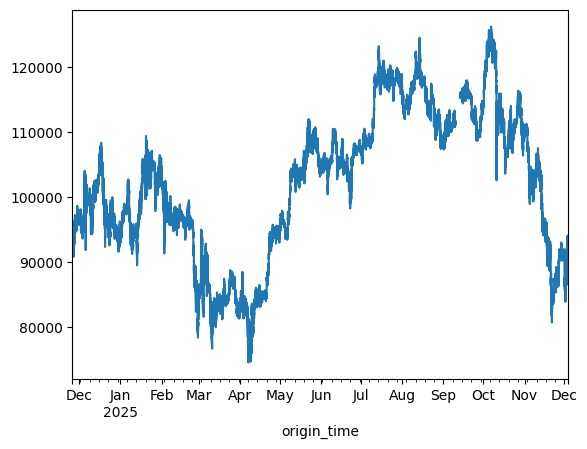

In [10]:
btc_df['ask_0_price'].plot()

In [11]:
btc_df['ask_0_price'].isna().sum()/len(btc_df)

np.float64(0.009702052924237911)

In the case of BTC, missing data is quite miniscule (<1% of total data). 

In [12]:
btc_df.to_parquet('data/btc_level1crypto_origin_times_resampled.parquet')

# Option 2 - Use origin time, and front-fill missing data (All coins )

The second option is to directly resample based on origin time and then front-fill missing data.

##TODO - Fix up this last part by using loop instead of groupby to avoid indexing ambiguity 

In [7]:
good_origin_times_df = good_origin_times_df.set_index('origin_time')

In [3]:
#good_origin_times_df.to_parquet('data/good_origin_times_df.parquet')
good_origin_times_df = pd.read_parquet('data/good_origin_times_df.parquet')

In [ ]:
# results = []
# BASE_TIME = pd.Timestamp('2024-11-26 00:00:00')
# for symbol, group in good_origin_times_df.groupby('symbol'):
#     resampled = get_closing_prices_by_symbol(group, base_time=BASE_TIME)
#     resampled['symbol'] = symbol
#     results.append(resampled)

# resampled_df = pd.concat(results, axis=0)

In [ ]:
#For every symbol, resample and then reset the index 
resampled_df = good_origin_times_df.groupby('symbol').apply(lambda x: get_closing_prices_by_symbol(x, base_time = BASE_TIME))

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_983/2362127687.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resampled_df = good_origin_times_df.groupby('symbol').apply(lambda x: get_closing_prices_by_symbol(x, base_time = BASE_TIME))
/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_983/1354886330.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return group.sort_index(ascending=True).resample(freq, origin=base_time).last()
/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_983/2362127687.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_gr

In [9]:
#Quick inspection of the data 
resampled_df.groupby('symbol').apply(lambda x: x.index.min())

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_983/707263953.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resampled_df.groupby('symbol').apply(lambda x: x.index.min())
/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_983/707263953.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df.groupby('symbol').apply(lambda x: x.index.min())


symbol
BTC-USDT    2024-11-26 00:00:00
ETH-USDT    2024-11-26 00:00:00
XRP-USDT    2024-11-26 00:00:00
BNB-USDT    2024-11-26 00:00:00
SOL-USDT    2024-11-26 00:00:00
TRX-USDT    2024-11-26 00:00:00
DOGE-USDT   2024-11-26 00:00:00
ADA-USDT    2024-11-26 00:00:00
XLM-USDT    2025-09-03 13:39:20
WBTC-USDT   2024-11-26 00:00:00
dtype: datetime64[ns]

In [23]:
resampled_df.head(n=20)

,received_time,bid_0_price,ask_0_price,bid_0_size,ask_0_size,symbol,exchange,mid_price
origin_time,,,,,,,,
2024-11-26 00:00:00,2024-11-26 00:00:09.917025536,92935.90,92935.91,2.55032,0.36348,BTC-USDT,BINANCE,92935.905
2024-11-26 00:00:10,2024-11-26 00:00:19.816896512,93154.46,93154.47,1.00850,1.57237,BTC-USDT,BINANCE,93154.465
2024-11-26 00:00:20,2024-11-26 00:00:29.516736256,93034.63,93034.64,0.00271,3.10595,BTC-USDT,BINANCE,93034.635
2024-11-26 00:00:30,2024-11-26 00:00:39.916487680,93071.42,93071.43,1.34965,0.00041,BTC-USDT,BINANCE,93071.425
2024-11-26 00:00:40,2024-11-26 00:00:49.632005376,93028.00,93028.75,0.00540,0.00265,BTC-USDT,BINANCE,93028.375
2024-11-26 00:00:50,2024-11-26 00:00:59.516931328,92995.99,92996.00,1.76222,1.04494,BTC-USDT,BINANCE,92995.995
2024-11-26 00:01:00,2024-11-26 00:01:09.816459520,93087.98,93087.99,0.76215,0.45824,BTC-USDT,BINANCE,93087.985
2024-11-26 00:01:10,2024-11-26 00:01:19.517200384,92966.50,92966.51,0.72422,1.52109,BTC-USDT,BINANCE,92966.505
2024-11-26 00:01:20,2024-11-26 00:01:29.816730112,92994.19,92994.20,1.98210,0.53530,BTC-USDT,BINANCE,92994.195


### Check for missing datetimes/gaps 

To focus on missing datetime/gaps, we will just do a pivot and look at mid-prices (since that's usually what we start with, anyway). 

In [ ]:
#how much missing data?
prices_df = resampled_df.pivot(columns = 'symbol', values = 'ask_0_price')
num_null_by_symbol = prices_df.isna().sum()
num_null_by_symbol/len(prices_df)

symbol
BTC-USDT     0.009702
ETH-USDT     0.198190
XRP-USDT     0.013059
BNB-USDT     0.198344
SOL-USDT     0.013493
TRX-USDT     0.000543
DOGE-USDT    0.013060
ADA-USDT     0.013777
XLM-USDT     0.768455
WBTC-USDT    0.044726
dtype: float64

For reference, I will also visualise the price charts to start off with. 

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

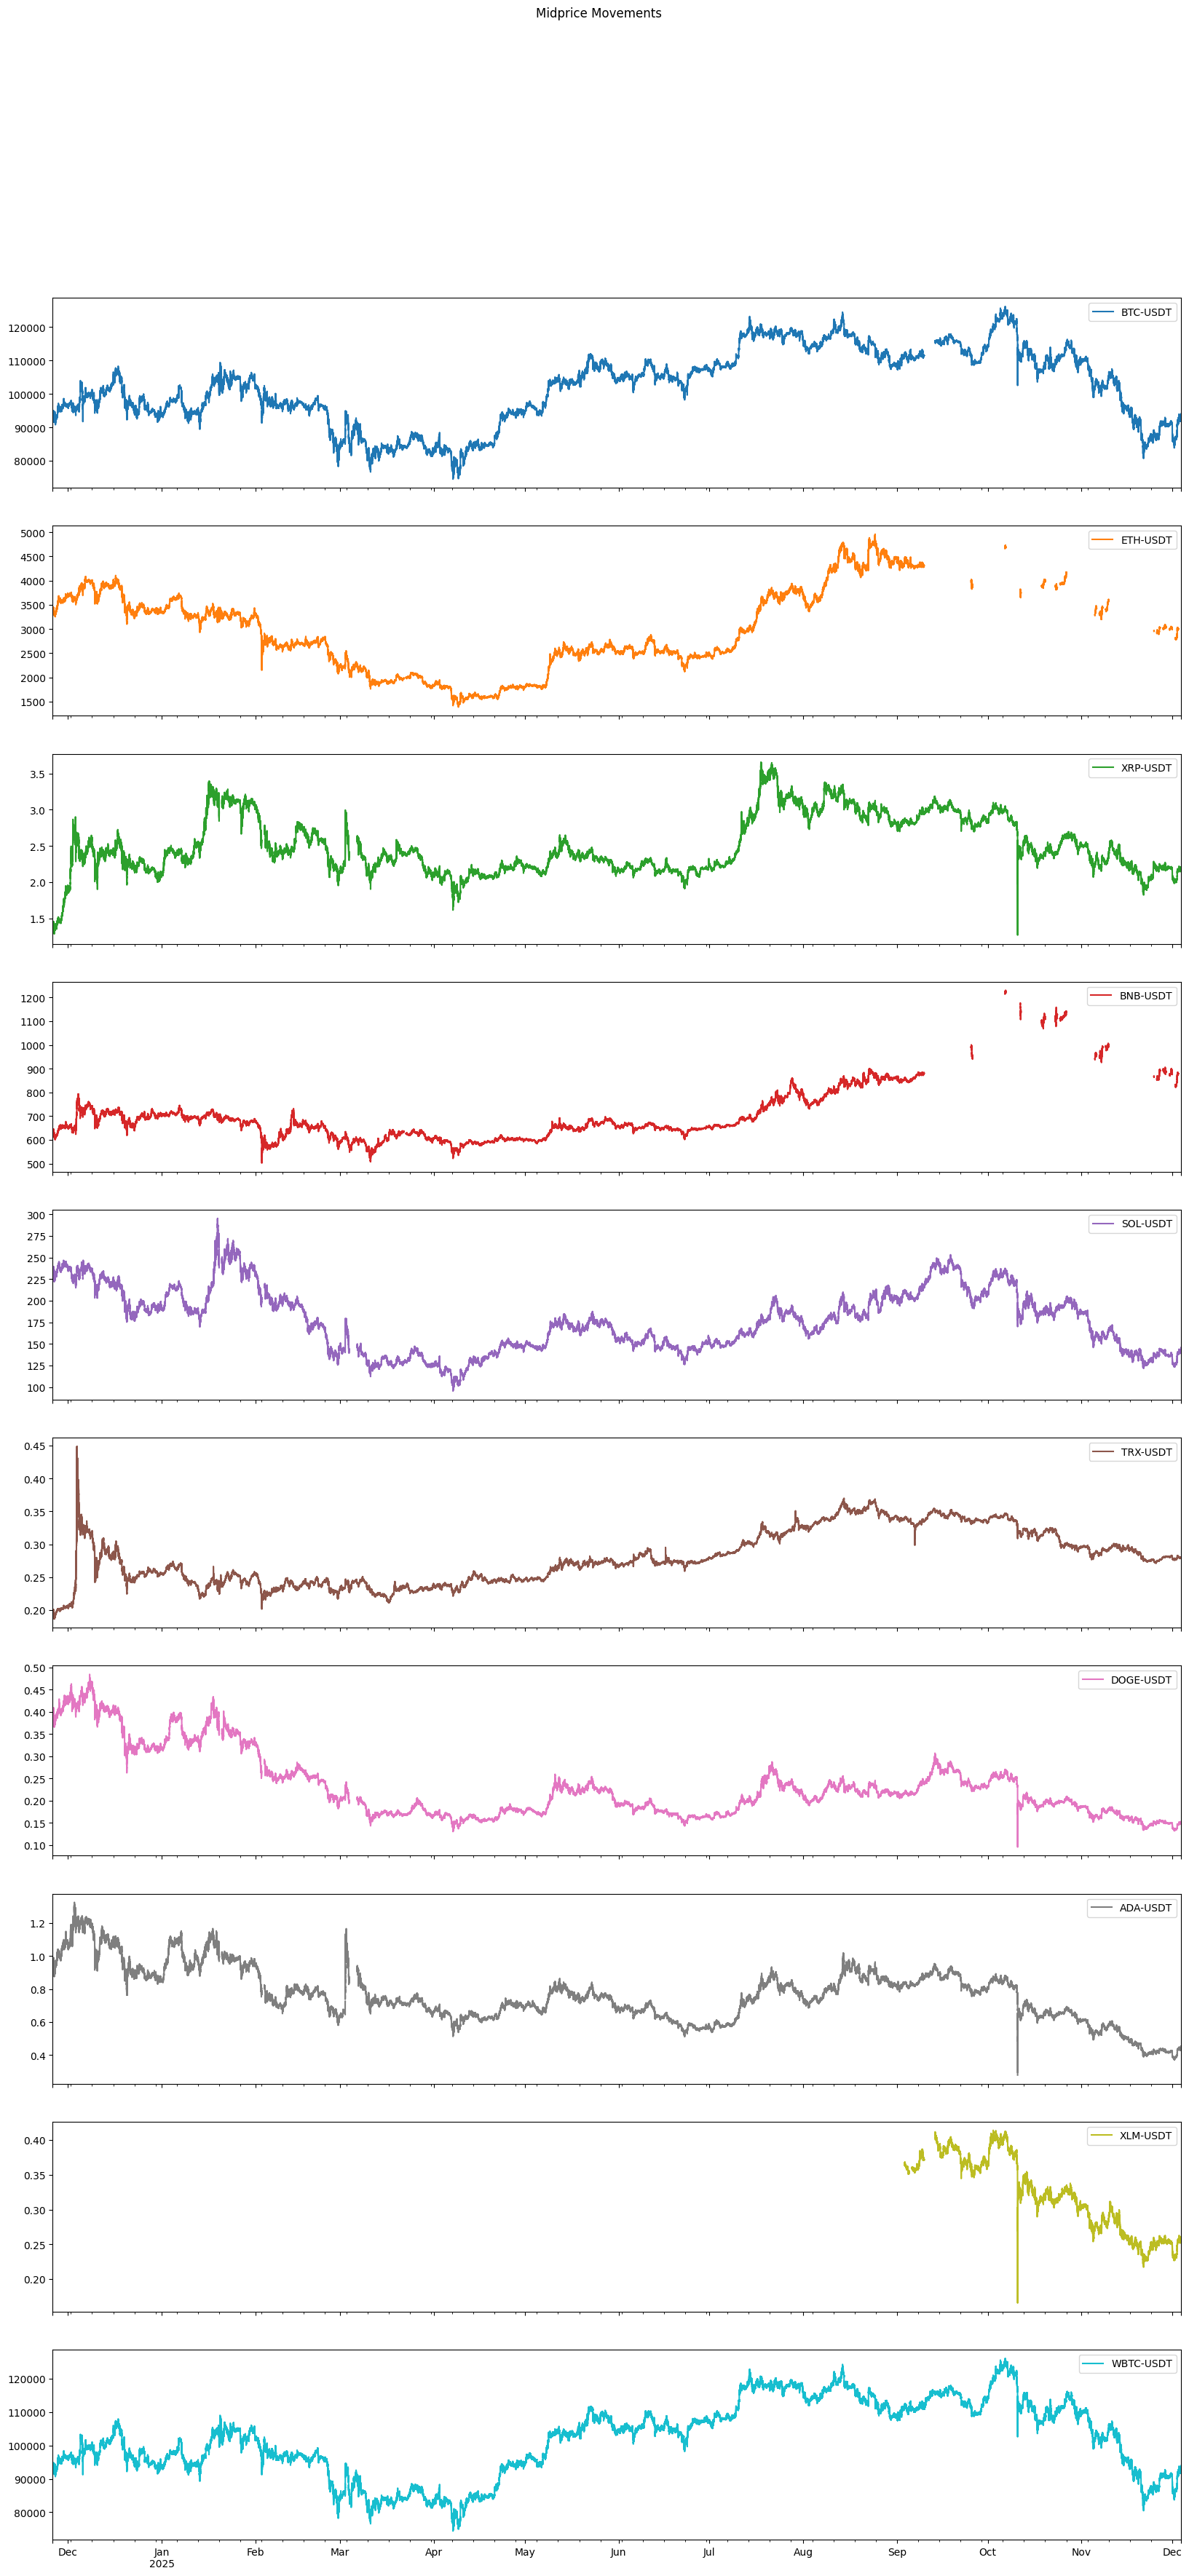

In [ ]:
prices_df.plot(figsize=(20, 40), title = 'Ask price Movements', subplots = True)

Conclusion - Option 2 is probably better, so we will just use origin times. 

In [29]:
# Record to Parquet 
resampled_df.to_parquet('data/level1crypto_raw_origin_times_resampled.parquet')